# Visualize Data from the Hyper-Angular Rainbow Polarimeter (HARP2)

**Authors:** Sean Foley (NASA, MSU), Meng Gao (NASA, SSAI), Ian Carroll (NASA, UMBC)

> **PREREQUISITES**
>
> This notebook has the following prerequisites:
> - An **<a href="https://urs.earthdata.nasa.gov/" target="_blank">Earthdata Login</a>**
>   account is required to access data from the NASA Earthdata system, including NASA ocean color data.
> - Learn with OCI: <a href="https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/" target="_blank">Data Access</a>

## Summary

PACE has two Multi-Angle Polarimeters (MAPs): [SPEXOne](https://pace.oceansciences.org/spexone.htm) and [HARP2](https://pace.oceansciences.org/harp2.htm). These sensors offer unique data, which is useful for its own scientific purposes and also complements the data from OCI. Working with data from the MAPs requires you to understand both multi-angle data and some basic concepts about polarization. This notebook will walk you through some basic understanding and visualizations of multi-angle polarimetry, so that you feel comfortable incorporating this data into your future projects.

## Learning objectives

At the end of this notebook you will know:

* How to acquire data from HARP2
* How to plot geolocated imagery
* Some basic concepts about polarization
* How to make animations of multi-angle data

<a name="toc"></a>
## Contents

1. [Setup](#setup)
1. [Get Level-1C Data](#data)
1. [Understanding Multi-Angle Data](#multiangle)
1. [Understanding Polarimetry](#polarimetry)
1. [Radiance to Reflectance](#reflectance)
1. [Animating an Overpass](#animation)

<a name="setup"></a>
## 1. Setup

First, import the libraries we will need.

In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory

from apng import APNG
from scipy.ndimage import gaussian_filter1d
import cartopy.crs as ccrs
import earthaccess
import imageio
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

The radiances collected by HARP2 often need to be converted, using additional properties, to reflectances. Write a function for anything you'll repeat like this.

In [2]:
def rad_to_refl(rad, f0, sza, r):
    """Convert radiance to reflectance.
    Args:
        rad: Radiance.
        f0: Solar irradiance.
        sza: Solar zenith angle.
        r: Sun-Earth distance (in AU).

    Returns: Reflectance.
    """
    return (r**2) * np.pi * rad / np.cos(sza * np.pi / 180) * f0

[Back to top](#toc)
<a name="data"></a>
## 2. Get Level-1C Data

Download some HARP2 Level-1C data using the `short_name` value "PACE_HARP2_L1C_SCI" in `earthaccess.search_data`. Level-1C corresponds to geolocated imagery. This means the imagery coming from the satellite has been calibrated and assigned to locations on the Earth's surface. Note that this might take a while, depending on the speed of your internet connection, and the progress bar will seem frozen because we're only downloading one file.

In [3]:
auth = earthaccess.login(persist=True)

In [4]:
tspan = ("2024-05-20", "2024-05-20")
results = earthaccess.search_data(
    short_name="PACE_HARP2_L1C_SCI",
    temporal=tspan,
    count=1,
)

Granules found: 1


In [5]:
paths = earthaccess.open(results)

Opening 1 granules, approx size: 0.62 GB
using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
prod = xr.open_dataset(paths[0])
view = xr.open_dataset(paths[0], group="sensor_views_bands").squeeze()
geo = xr.open_dataset(paths[0], group="geolocation_data")
obs = xr.open_dataset(paths[0], group="observation_data").squeeze()

[Back to top](#toc)
<a name="multiangle"></a>
## 2. Understanding Multi-Angle Data

HARP2 is a multi-spectral sensor, like OCI, with 4 spectral bands. These roughly correspond to green, red, near infrared (NIR), and blue (in that order). HARP2 is also multi-angle. These angles are with respect to the satellite track. Essentially, HARP2 is always looking ahead, looking behind, and everywhere in between. The number of angles varies per sensor. The red band has 60 angles, while the green, blue, and NIR bands each have 10.

In the HARP2 data, the angles and the spectral bands are combined into one axis. I'll refer to this combined axis as HARP2's "channels." Below, we'll make a quick plot both the viewing angles and the wavelengths of HARP2's channels. In both plots, the x-axis is simply the channel index.

Pull out the view angles and wavelengths.

In [7]:
angles = view["sensor_view_angle"]
wavelengths = view["intensity_wavelength"]

Create a figure with 2 rows and 1 column and a reasonable size for many screens.

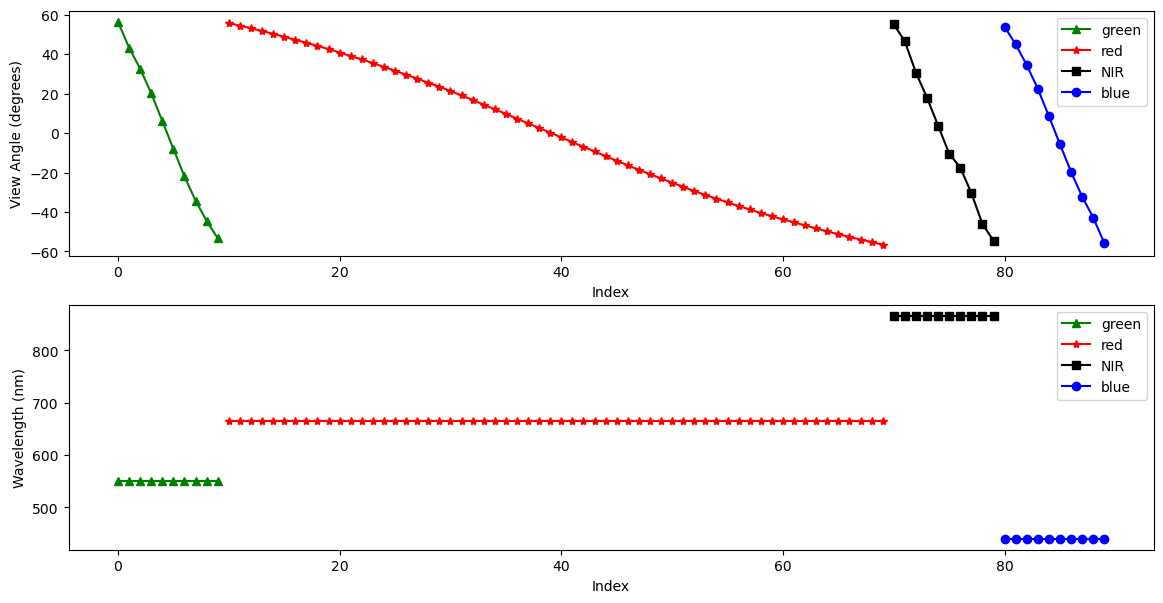

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].set_ylabel("View Angle (degrees)")
ax[0].set_xlabel("Index")
ax[1].set_ylabel("Wavelength (nm)")
ax[1].set_xlabel("Index")
plot_data = [
    (0, 10, "green", "^", "green"),
    (10, 70, "red", "*", "red"),
    (70, 80, "black", "s", "NIR"),
    (80, 90, "blue", "o", "blue"),
]
for start_idx, end_idx, color, marker, label in plot_data:
    ax[0].plot(
        np.arange(start_idx, end_idx),
        angles[start_idx:end_idx],
        color=color,
        marker=marker,
        label=label,
    )
    ax[1].plot(
        np.arange(start_idx, end_idx),
        wavelengths[start_idx:end_idx],
        color=color,
        marker=marker,
        label=label,
    )
ax[0].legend()
ax[1].legend()
plt.show()

[Back to top](#toc)
<a name="polarimetry"></a>
## 3. Understanding Polarimetry

HARP2 is sensitive to the polarization of light. Polarization describes the geometric orientation of the oscillation of light waves. Randomly polarized light (like light coming directly from the sun) has an approximately equal amount of waves in every orientation. When light reflects of certain surfaces, it can become nonrandomly polarized.

Polarimetric data is typically represented using [Stokes vectors](https://en.wikipedia.org/wiki/Stokes_parameters). These have four components: I, Q, U, and V. HARP2 is only sensitive to linear polarization, and does not detect circular polarization. Since the V component corresponds to circular polarization, the data only includes the I, Q, and U elements of the Stokes vector.

Let's make a plot of the I, Q, and U components of our Stokes vector, using the RGB channels, which will help our eyes make sense of the data. We'll use the view that is closest to pointing straight down, which is called the "nadir" view in the code. It is important to understand that, because HARP2 is a pushbroom sensor with a wide swath, the sensor zenith angle at the edges of the swath will still be high. It's only a true nadir view close to the center of the swath. Still, the average sensor zenith angle will be lowest in this view.)

The I, Q, and U components of the Stokes vector are separate variables in the `obs` dataset.

In [9]:
stokes = obs[["i", "q", "u"]]

The first 10 channels are green, the next 60 channels are red, and the final 10 channels are blue (we're skipping NIR).
In each of those groups of channels, we get the index of the minimum absolute value of the camera angle, corresponding to our nadir view.

In [10]:
green_nadir_idx = np.argmin(np.abs(angles[:10].values))
red_nadir_idx = 10 + np.argmin(np.abs(angles[10:70].values))
blue_nadir_idx = 80 + np.argmin(np.abs(angles[80:].values))

Then, get the data at the nadir indices.

In [11]:
rgb_stokes = stokes.isel(
    {
        "number_of_views": [red_nadir_idx, green_nadir_idx, blue_nadir_idx],
    }
)

A few adjustments make the image easier to visualize. First, normalize the data between 0 and 1. Second, bring out some of the darker colors.

In [12]:
rgb_stokes = (rgb_stokes - rgb_stokes.min()) / (rgb_stokes.max() - rgb_stokes.min())
rgb_stokes = rgb_stokes ** (3 / 4)

Add latitude and longitude as auxilliary (i.e. non-index) coordinates to use in the map projection.

In [13]:
rgb_stokes = rgb_stokes.assign_coords(
    {
        "lat": geo["latitude"],
        "lon": geo["longitude"],
    }
)

Since the nadir view is not processed at swath edges, a better image will result from finding a valid window within the dataset. Using just the array for the I component, we crop the `rgb_stokes` dataset using the `where` attribute and some boolean logic applied across different dimensions of the array.

In [14]:
window = rgb_stokes["i"].notnull().all("number_of_views")
crop_rgb_stokes = rgb_stokes.where(
    window.any("bins_along_track") & window.any("bins_across_track"),
    drop=True,
)

The granule crosses the 180 degree longitude, so we set up the figure and subplots to use a Plate Carree projection shifted to center on a -170 longitude. The data has coordinates from the default (i.e. centered at 0 longitude) Plate Carree projection, so we give that CRS as a `transform`.

The figure will hav 1 row and 3 columns, for each of the I, Q, and U arrays, spanning a width suitable for many screens.

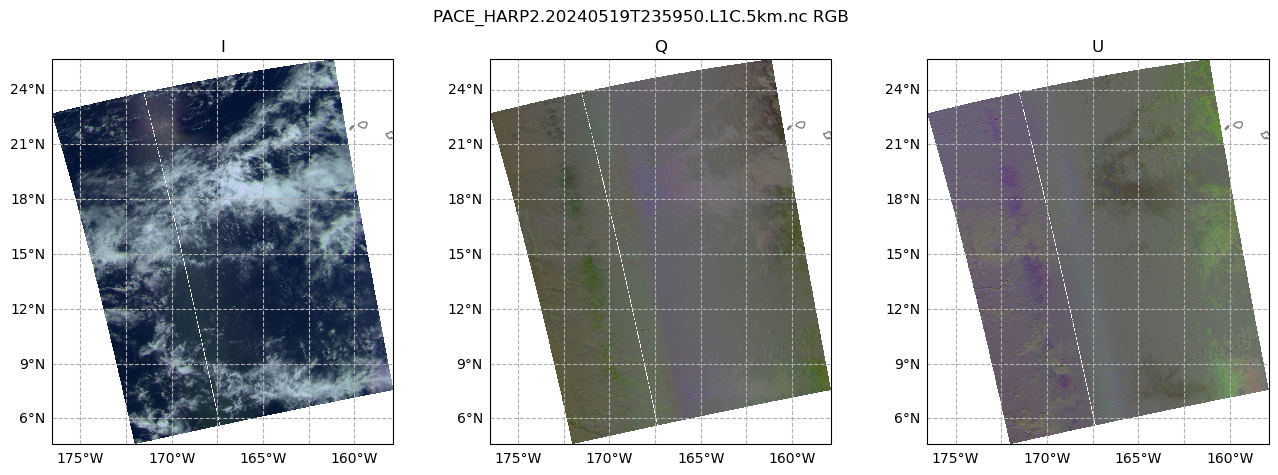

In [15]:
crs = ccrs.PlateCarree(-170)
fig, ax = plt.subplots(1, 3, figsize=(16, 5), subplot_kw={"projection": crs})
fig.suptitle(f'{prod.attrs["product_name"]} RGB')

for i, (key, value) in enumerate(crop_rgb_stokes.items()):
    ax[i].pcolormesh(value["lon"], value["lat"], value, transform=ccrs.PlateCarree())
    ax[i].gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--")
    ax[i].coastlines(color="grey")
    ax[i].set_title(key.capitalize())

It's pretty plain to see that the I plot makes sense to the eye: we can see clouds over the Pacific Ocean (this scene is south of the Cook Islands and east of Australia). This is because the I component of the Stokes vector corresponds to the total intensity. In other words, this is roughly what your eyes would see. However, the Q and U plots don't quite make as much sense to the eye. We can see that there is some sort of transition in the middle, which is the satellite track. This transition occurs in both plots, but is stronger in Q. This gives us a hint: the type of linear polarization we see in the scene depends on the angle with which we view the scene.

[This Wikipedia plot](https://upload.wikimedia.org/wikipedia/commons/3/31/StokesParameters.png) is very helpful for understanding what exactly the Q and U components of the Stokes vector mean. Q describes how much the light is oriented in -90°/90° vs. 0°/180°, while U describes how much light is oriented in -135°/45°; vs. -45°/135°.

Next, let's take a look at the degree of linear polarization (DoLP).

In [16]:
rgb_dolp = obs["dolp"].isel(
    {
        "number_of_views": [red_nadir_idx, green_nadir_idx, blue_nadir_idx],
    }
)
crop_rgb_dolp = rgb_dolp.where(
    window.any("bins_along_track") & window.any("bins_across_track"),
    drop=True,
)
crop_rgb = xr.merge((crop_rgb_dolp, crop_rgb_stokes))

Create a figure with 1 row and 2 columns, having a good width for many screens, that will use the projection defined above. For the two columns, we iterate over just the I and DoLP arrays.

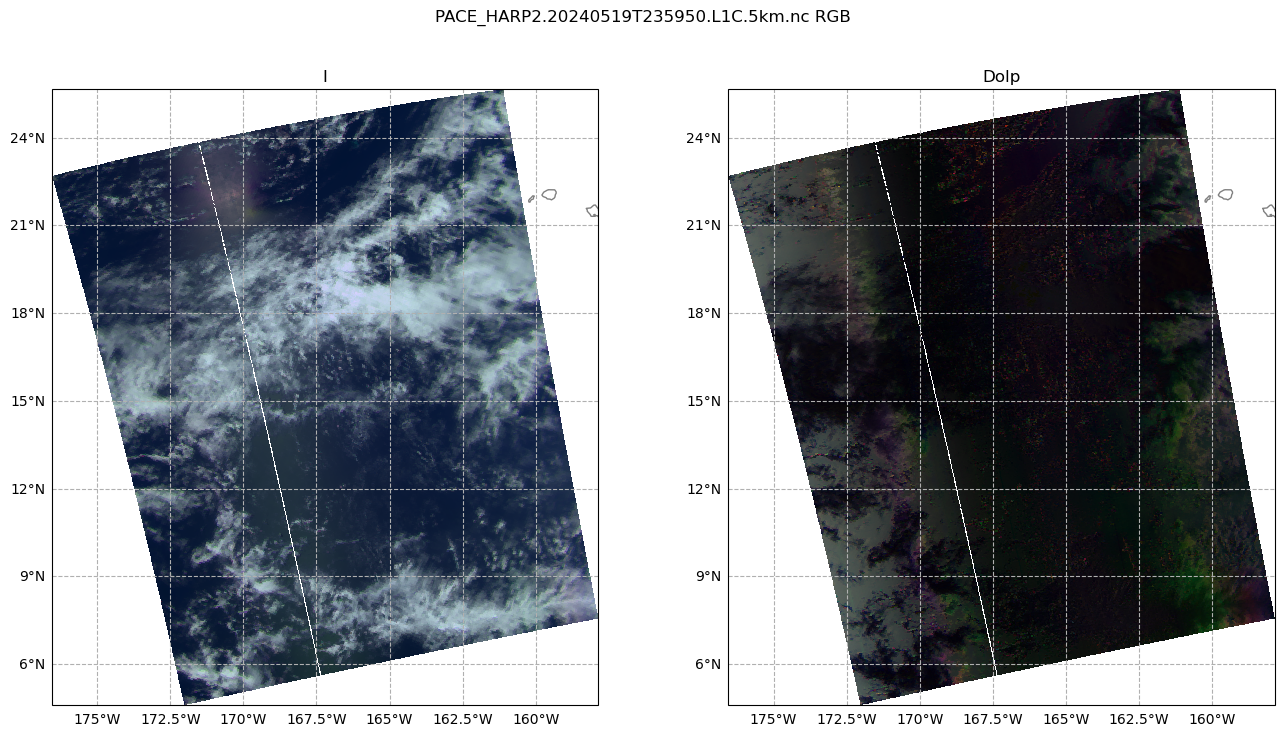

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={"projection": crs})
fig.suptitle(f'{prod.attrs["product_name"]} RGB')

for i, (key, value) in enumerate(crop_rgb[["i", "dolp"]].items()):
    ax[i].pcolormesh(value["lon"], value["lat"], value, transform=ccrs.PlateCarree())
    ax[i].gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--")
    ax[i].coastlines(color="grey")
    ax[i].set_title(key.capitalize())

DoLP line plot

In [18]:
dolp_mean = obs["dolp"].mean(["bins_along_track", "bins_across_track"])
dolp_mean = (dolp_mean - dolp_mean.min()) / (dolp_mean.max() - dolp_mean.min())

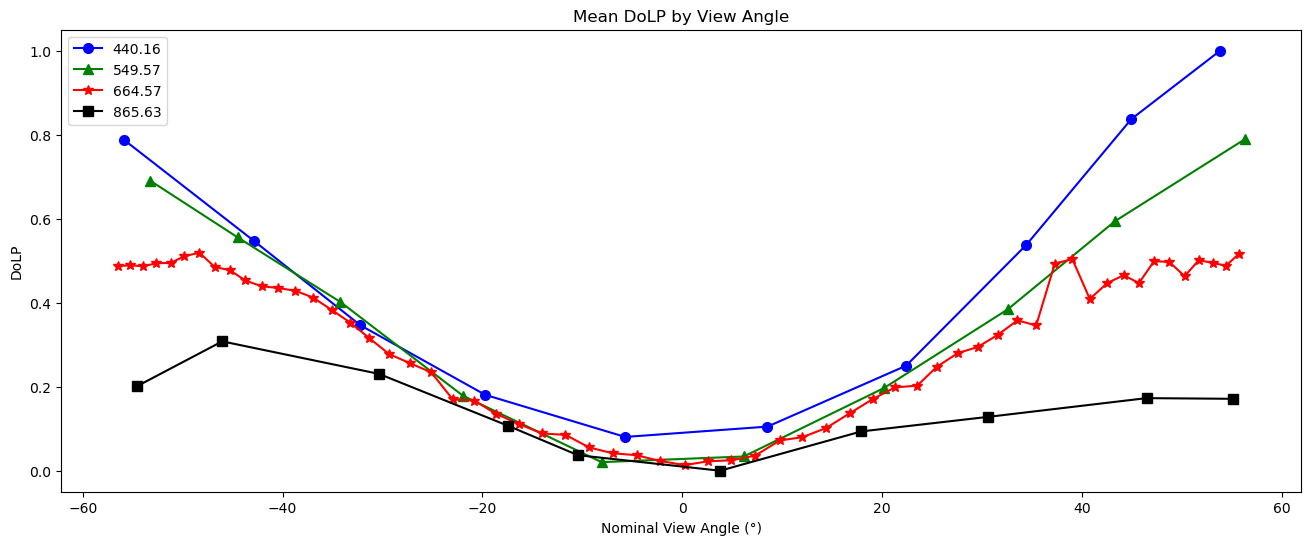

In [19]:
fig, ax = plt.subplots(figsize=(16, 6))
wv_uq = np.unique(wavelengths.values)
plot_data = [("b", "o"), ("g", "^"), ("r", "*"), ("k", "s")]
for wv_idx in range(4):
    wv = wv_uq[wv_idx]
    wv_mask = wavelengths.values == wv
    c, m = plot_data[wv_idx]
    ax.plot(
        angles.values[wv_mask],
        dolp_mean[wv_mask],
        color=c,
        marker=m,
        markersize=7,
        label=str(wv),
    )
ax.legend()
ax.set_xlabel("Nominal View Angle (°)")
ax.set_ylabel("DoLP")
ax.set_title("Mean DoLP by View Angle")
plt.show()

[Back to top](#toc)
<a name='reflectance'></a>
## 4. Radiance to Reflectance

We can convert radiance into reflectance. For a more in-depth explanation, see [here](https://seadas.gsfc.nasa.gov/help-9.0.0/rad2refl/Rad2ReflAlgorithmSpecification.html#:~:text=Radiance%20is%20the%20variable%20directly,it%2C%20and%20it%20is%20dimensionless). This conversion compensates for the differences in appearance due to the viewing angle and sun angle.

The difference in appearance (after matplotlib automatically normalizes the data) is negligible, but the difference in the physical meaning of the array values is quite important.

In [20]:
refl = rad_to_refl(
    rad=obs["i"],
    f0=view["intensity_f0"],
    sza=geo["solar_zenith_angle"],
    r=float(prod.attrs["sun_earth_distance"]),
)

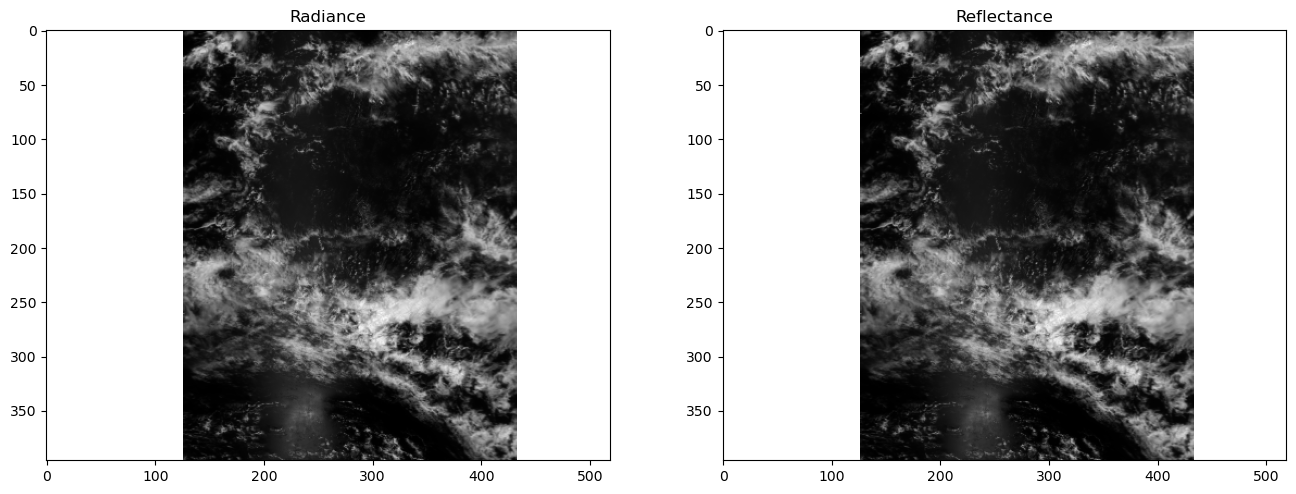

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(obs["i"].sel({"number_of_views": red_nadir_idx}), cmap="gray")
ax[0].set_title("Radiance")
ax[1].imshow(refl.sel({"number_of_views": red_nadir_idx}), cmap="gray")
ax[1].set_title("Reflectance")
plt.show()

Create a line plot of the mean reflectance for each view angle and spectral channel. The flatness of this plot serves as a sanity check that nothing has gone horribly wrong with our data processing.

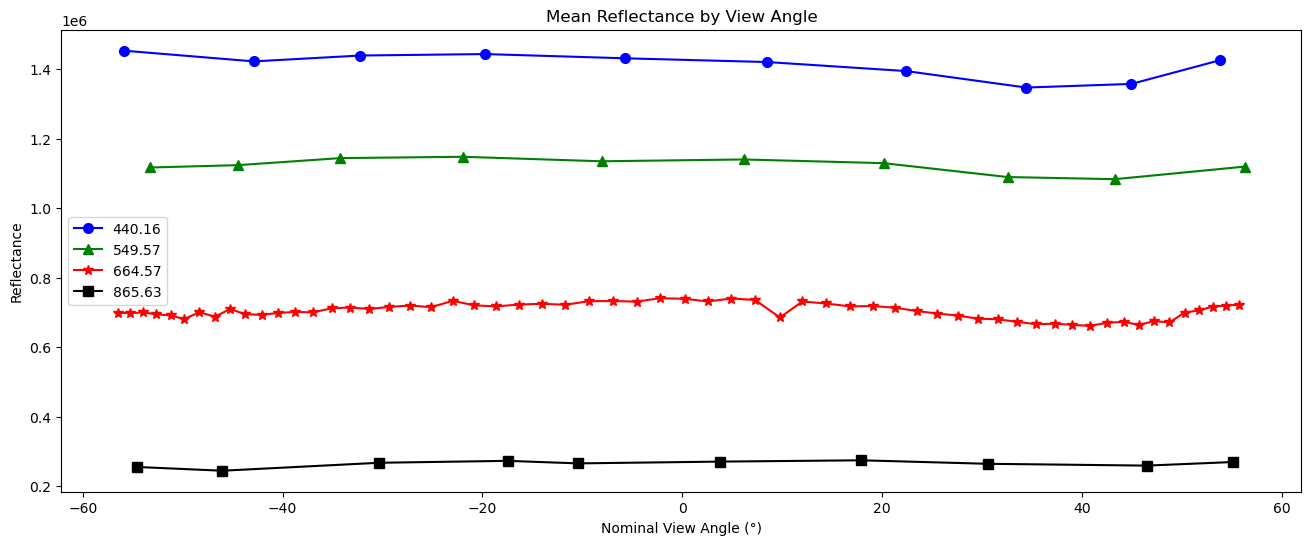

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))
wv_uq = np.unique(wavelengths.values)
plot_data = [("b", "o"), ("g", "^"), ("r", "*"), ("black", "s")]
refl_mean = refl.mean(["bins_along_track", "bins_across_track"])
for wv_idx in range(4):
    wv = wv_uq[wv_idx]
    wv_mask = wavelengths.values == wv
    c, m = plot_data[wv_idx]
    ax.plot(
        angles.values[wv_mask],
        refl_mean[wv_mask],
        color=c,
        marker=m,
        markersize=7,
        label=str(wv),
    )

ax.legend()
ax.set_xlabel("Nominal View Angle (°)")
ax.set_ylabel("Reflectance")
ax.set_title("Mean Reflectance by View Angle")
plt.show()

[Back to top](#toc)
<a name='animation'>
## 5. A Simple Animation

<div class="alert alert-info" role="alert">
<p>WARNING: there is some flickering in the animation displayed in this section.</p>
</div>

All that is great for looking at a single angle at a time, but it doesn't capture the multi-angle nature of the instrument. Multi-angle data innately captures information about 3D structure. To get a sense of that, we'll make an animation of the scene with the 60 viewing angles available for the red band.

Note: you can generate this animation with geolocated data as well, using `pcolormesh` as shown in the above code blocks. However, this can be a little slow for multi-angle data, so for now we'll just use the un-interpolated arrays. This means there will be some stripes of what seems like missing data at certain angles. These stripes actually result from the gridding of the multi-angle data, and are not a bug.

Create an animated PNG object.

In [23]:
anim = APNG()

Get the reflectances of just the red channel, and normalize the reflectance to lie between 0 and 1.

In [24]:
refl_red = refl[..., 10:70]
refl_pretty = (refl_red - refl_red.min()) / (refl_red.max() - refl_red.min())

A very mild Gaussian filter over the angular axis will improve the animation's smoothness.

In [25]:
refl_pretty.data = gaussian_filter1d(refl_pretty, sigma=0.5, truncate=2, axis=2)

Raising the image to the power 2/3 will brighten it a little bit. Cast it to an unsigned 8-bit integer so we can write it to a png later.

In [26]:
refl_pretty = refl_pretty ** (2 / 3)
refl_pretty.data[np.isnan(refl_pretty)] = 0  # set all of our not-a-number (NaN) values to 0
refl_pretty = (255 * refl_pretty).astype(np.uint8)

Append all but the first and last frame in reverse order, to get a 'bounce' effect.

In [27]:
frames = np.concatenate([refl_pretty, refl_pretty[..., -1:1:-1]], axis=2)

Save each frame to this directory and append the files to our animated PNG object
Make a temporary directory to dump frames into.

In [28]:
with TemporaryDirectory() as tmp:
    for i in range(frames.shape[2]):
        frame = frames[..., i]
        path = Path(tmp) / f"{i:04d}.png"
        imageio.imwrite(path, frame)
        anim.append_file(path, delay=i)
    anim.save(f'harp2_red_anim_{prod.attrs["product_name"].split(".")[1]}.png')

Check it out! This is a great example of multi-layer clouds. You can use the parallax effect to distinguish between these layers.

The [sunglint](https://en.wikipedia.org/wiki/Sunglint) is an obvious feature, but you can also make out the [opposition effect](https://en.wikipedia.org/wiki/Opposition_surge) on some of the clouds in the scene. These details would be far harder to identify without multiple angles!

![A multi-angle HARP2 animation](harp2_red_anim_20240519T235950.png)